In [1]:
import construction as cs
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp


import dynamic_metrics as ds


import matplotlib.pyplot as plt

### read font
from matplotlib import font_manager

font_dirs = ['Barlow/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Barlow'

import networkx as nx
%matplotlib inline
%config InlineBackend.figure_format = 'retina'




%load_ext autoreload
%autoreload 2

In [12]:
def load_origin_graph(file_name,gap=299):
    data_in = cs.load_data("../Datasets/"+file_name+".dat")
    graphs_in = cs.build_graphs(data_in,gap=gap)
    return graphs_in

def load_ETNgen_graph(file_name):
    data_in = cs.load_data("../Generated_graphs/ETNgen-"+file_name+".dat")
    gap = 299 
    graphs_in = cs.build_graphs(data_in,gap=gap)
    return graphs_in


def load_tag_graph(file_name):
    data_in = cs.load_data("../Competitors_generated_graphs/TagGen/"+file_name+"_generato_TagGen.dat")
    gap = 0 
    graphs_in = cs.build_graphs(data_in,gap=gap)
    return graphs_in



In [111]:
file_name = "DTU_SMS_1sett"
orig_graphs = load_origin_graph(file_name,gap=599)
etn_gen = load_ETNgen_graph(file_name)
tag_gen = load_tag_graph(file_name+"_599")

In [112]:
print(len(orig_graphs),len(tag_gen),len(etn_gen))

1007 1007 1008


In [113]:
import os
file_name = "DTU_SMS_1set"
path = "dynamic_results/SI/"+file_name
COV = path+"/coverage"
MFPTs = path+"/MFPT"

if not os.path.exists(path):
    os.makedirs(path)
    os.makedirs(COV)
    os.makedirs(MFPTs)

# coverage

k volte, con n0 e t0 random

In [114]:
from scipy.stats import ks_2samp

In [115]:
K = 1000
T = 500
c_orig = ds.coverage(orig_graphs,K,T)
c_stab = ds.coverage(orig_graphs,K,T)
c_mio = ds.coverage(etn_gen,K,T)
c_tag = ds.coverage(tag_gen,K,T)

print("coverage")
print("orig vs sta \t",ks_2samp(c_orig, c_stab)[0])
print("orig vs etn \t",ks_2samp(c_orig, c_mio)[0])
print("orig vs tag \t",ks_2samp(c_orig, c_tag)[0])

np.save(COV+"/stab",c_stab)
np.save(COV+"/orig",c_orig)
np.save(COV+"/tag",c_tag)
np.save(COV+"/etn",c_mio)

coverage
orig vs sta 	 0.011
orig vs etn 	 0.503
orig vs tag 	 0.35


In [116]:
print("MFPS")
print("orig vs sta \t",compute_kl_divergence(c_orig, c_stab))
print("orig vs etn \t",compute_kl_divergence(c_orig, c_mio))
print("orig vs tag \t",compute_kl_divergence(c_orig, c_tag))

MFPS
orig vs sta 	 0.006045634174251761
orig vs etn 	 0.6995101414133583
orig vs tag 	 0.23768883388133547


# MFPT

In [117]:
file_name = "DTU_SMS_1set"

path = "dynamic_results/SI/"+file_name
MFPTs = path+"/MFPT"

orig_graphs = load_origin_graph(file_name+"t",gap=599)
etn_gen = load_ETNgen_graph(file_name+"t")
tag_gen = load_tag_graph(file_name+"t_599")
print(MFPTs)
print(len(orig_graphs),len(tag_gen),len(etn_gen))

dynamic_results/SI/DTU_SMS_1set/MFPT
1007 1007 1008


In [118]:
K = 1
m_ori = ds.MFPT(orig_graphs,K)
print(1)
m_stb = ds.MFPT(orig_graphs,K)
print(2)
m_etn = ds.MFPT(etn_gen,K)
print(3)
m_tag = ds.MFPT(tag_gen,K)
print(6)

1
2
3
6


In [120]:
print("MFPS")
print("orig vs sta \t",compute_kl_divergence(m_ori, m_stb))
print("orig vs etn \t",compute_kl_divergence(m_ori, m_etn))
print("orig vs tag \t",compute_kl_divergence(m_ori, m_tag))

MFPS
orig vs sta 	 9.996384913720631e-06
orig vs etn 	 3.778168393406012
orig vs tag 	 0.0017530499726690686


In [121]:
np.save(MFPTs+"/stab",m_stb)
np.save(MFPTs+"/orig",m_ori)
np.save(MFPTs+"/tag",m_tag)
np.save(MFPTs+"/etn",m_etn)

In [71]:
def compute_probs(data, n=10): 
    data = np.array(data)
    h, e = np.histogram(data, n)
    p = h/data.shape[0]
    return e, p

def support_intersection(p, q): 
    sup_int = (
        list(
            filter(
                lambda x: (x[0]!=0) & (x[1]!=0), zip(p, q)
            )
        )
    )
    return sup_int

def get_probs(list_of_tuples): 
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

def kl_divergence(p, q): 
    return np.sum(p*np.log(p/q))

def js_divergence(p, q):
    m = (1./2.)*(p + q)
    return (1./2.)*kl_divergence(p, m) + (1./2.)*kl_divergence(q, m)

def compute_kl_divergence(train_sample, test_sample, n_bins=50): 
    """
    Computes the KL Divergence using the support 
    intersection between two different samples
    """
    E = 0.0000000001
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)
    
    p = np.array(p) + E 
    q = np.array(q) + E 
    
    p = p/sum(p)
    q = q/sum(q)
    
    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)
    
    return kl_divergence(p, q)


# SIR model

In [229]:
import os
file_name = "DTU_calls_1set"

path = "dynamic_results/SI/"+file_name
R0 = path+"/R0/"
la025 = R0+"la025"
la015 = R0+"la015"
la001 = R0+"la001"
if not os.path.exists(la001):
    os.makedirs(la025)
    os.makedirs(la015)
    os.makedirs(la001)
    

In [230]:
file_nametmp = "DTU_calls_1sett"
orig_graphs = load_origin_graph(file_nametmp,gap=599)
etn_gen = load_ETNgen_graph(file_nametmp)
tag_gen = load_tag_graph(file_nametmp+"_599")

In [231]:
print(len(orig_graphs),len(etn_gen),len(tag_gen))

1003 1005 1003


In [232]:
for lambd in [0.25,0.15,0.01]:
    
    if lambd == 0.25:
        la = la025
    if lambd == 0.15:
        la = la015
    if lambd == 0.01:
        la = la001
        
    K = 100
    mu = 0.005
    
    print("R0 lambda",lambd,la)
    r_ori = ds.compute_r0(K,orig_graphs,lambd,mu)
    r_sta = ds.compute_r0(K,orig_graphs,lambd,mu)
    r_etn = ds.compute_r0(K,etn_gen,lambd,mu)
    r_tag = ds.compute_r0(K,tag_gen,lambd,mu)
    
    r_ori  = r_ori/np.sum(r_ori)
    r_sta  = r_sta/np.sum(r_sta)
    r_etn  = r_etn/np.sum(r_etn)
    r_tag  = r_tag/np.sum(r_tag)
    
    print("orig vs sta \t",ks_2samp(r_ori, r_sta)[0])
    print("orig vs etn \t",ks_2samp(r_ori, r_etn)[0])
    print("orig vs tag \t",ks_2samp(r_ori, r_tag)[0])

    print("\n")
    print("orig vs sta \t",compute_kl_divergence(r_ori, r_sta))
    print("orig vs etn \t",compute_kl_divergence(r_ori, r_etn))
    print("orig vs tag \t",compute_kl_divergence(r_ori, r_tag))

    np.save(la+"/stab",r_sta)
    np.save(la+"/orig",r_ori)
    np.save(la+"/tag",r_tag)
    np.save(la+"/etn",r_etn)

R0 lambda 0.25 dynamic_results/SI/DTU_calls_1set/R0/la025
orig vs sta 	 0.49
orig vs etn 	 0.32
orig vs tag 	 0.38


orig vs sta 	 13.423123273296572
orig vs etn 	 13.613560220566892
orig vs tag 	 14.017661751831037
R0 lambda 0.15 dynamic_results/SI/DTU_calls_1set/R0/la015
orig vs sta 	 0.37
orig vs etn 	 0.29
orig vs tag 	 0.29


orig vs sta 	 9.242148963434344
orig vs etn 	 9.373936235455355
orig vs tag 	 9.768725933180917
R0 lambda 0.01 dynamic_results/SI/DTU_calls_1set/R0/la001
orig vs sta 	 0.03
orig vs etn 	 0.02
orig vs tag 	 0.06


orig vs sta 	 0.7518715194877343
orig vs etn 	 0.752281779491039
orig vs tag 	 0.8542359783156747


In [195]:
file_nametmp = "DTU_SMS_1sett"
orig_graphs = load_origin_graph(file_nametmp,gap=599)
etn_gen = load_ETNgen_graph(file_nametmp)
tag_gen = load_tag_graph(file_nametmp+"_599")

In [196]:
lambd = 0.15
r_ori = ds.compute_r0(K,orig_graphs,lambd,mu)
r_sta = ds.compute_r0(K,orig_graphs,lambd,mu)
r_etn = ds.compute_r0(K,etn_gen,lambd,mu)
r_tag = ds.compute_r0(K,tag_gen,lambd,mu)

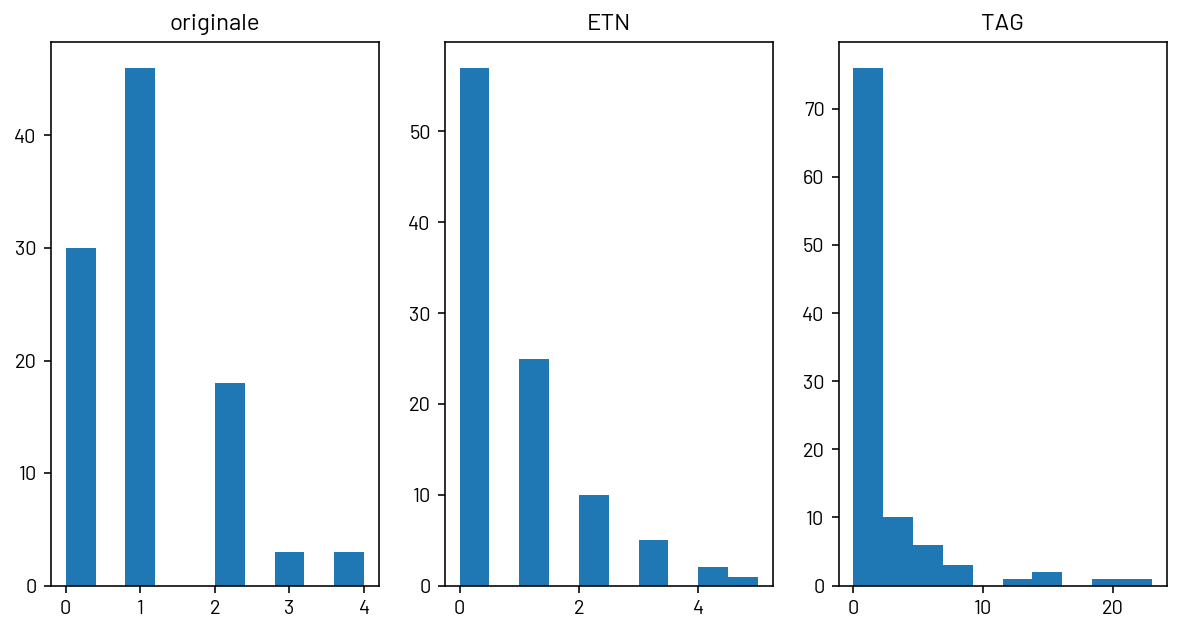

In [197]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title("originale")
plt.hist(r_ori)
plt.subplot(1,3,2)
plt.title("ETN")
plt.hist(r_etn)
plt.subplot(1,3,3)
plt.title("TAG")
plt.hist(r_tag)
plt.show()

In [198]:
r_ori2  = r_ori/np.sum(r_ori)
r_sta2  = r_sta/np.sum(r_sta)
r_etn2  = r_etn/np.sum(r_etn)
r_tag2  = r_tag/np.sum(r_tag)

In [199]:
print(compute_kl_divergence(r_ori,r_sta,50))
print(compute_kl_divergence(r_ori,r_etn,50))
print(compute_kl_divergence(r_ori,r_tag,50))

0.10600964272431598
0.18052644446906144
0.03132479605296474


In [200]:
print(compute_kl_divergence(r_ori2,r_sta2,50))
print(compute_kl_divergence(r_ori2,r_etn2,50))
print(compute_kl_divergence(r_ori2,r_tag2,50))

15.321546090189601
14.965897371697444
14.627297469770104


# plot

In [41]:

ORIGINAL_COLOR = '#474747' #dark grey
ETN_COLOR =  '#fb7041' #'#E5865E' # arancio
TAG_COLOR = '#96ccc8' # light blue
STM_COLOR = '#bad1f2' #8F2E27' # rosso
DYM_COLOR = '#559ca6' # teal

line_width = 1.5

In [73]:
def load_cov(file_name):
    
    ori = np.load("dynamic_results/SI/"+file_name+"/coverage/orig.npy")
    stb = np.load("dynamic_results/SI/"+file_name+"/coverage/stab.npy")
    etn = np.load("dynamic_results/SI/"+file_name+"/coverage/etn.npy")
    tag = np.load("dynamic_results/SI/"+file_name+"/coverage/tag.npy")
    
    return ori,stb,etn,tag


def load_mfpt(file_name):
    
    ori = np.load("dynamic_results/SI/"+file_name+"/MFPT/orig.npy")
    stb = np.load("dynamic_results/SI/"+file_name+"/MFPT/stab.npy")
    etn = np.load("dynamic_results/SI/"+file_name+"/MFPT/etn.npy")
    tag = np.load("dynamic_results/SI/"+file_name+"/MFPT/tag.npy")
    
    return ori,stb,etn,tag

def load_r0(file_name,lambd="la001"):
    
    ori = np.load("dynamic_results/SI/"+file_name+"/R0/"+lambd+"/orig.npy")
    stb = np.load("dynamic_results/SI/"+file_name+"/R0/"+lambd+"/stab.npy")
    etn = np.load("dynamic_results/SI/"+file_name+"/R0/"+lambd+"/etn.npy")
    tag = np.load("dynamic_results/SI/"+file_name+"/R0/"+lambd+"/tag.npy")
    
    return ori,stb,etn,tag

In [89]:

def plot_cov_mfpt3(ax,file_name,legend=False):
    
    
    if file_name == "High_School12":
        ax.set_title("High school 2")
    if file_name == "High_School13":
        ax.set_title("High school 3")
    if file_name == "primary_school":
        ax.set_title("Primary school")
        
        
    cov = load_cov(file_name)
    mfpt = load_mfpt(file_name)
    
    x = np.arange(2)
    cov_ms, mfpt_ms = compute_ks_cov_mfpt(cov,mfpt)
    x1 = np.array([cov_ms[0],mfpt_ms[0]])
    x2 = np.array([cov_ms[1],mfpt_ms[1]])
    x3 = np.array([cov_ms[2],mfpt_ms[2]])
    
    
    width = 0.2
    rects1 = ax.bar(x - 0.3, x2[:,0], width,  label='ETN-gen',color=ETN_COLOR)
    rects5 = ax.bar(x + 0.1, x3[:,0], width,  label='TagGen',color=TAG_COLOR)
    ax.plot([-0.45,0.45],[x1[0],x1[0]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    ax.plot([1-0.45,1.45],[x1[1],x1[1]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    
              
    ax.tick_params(bottom=False, right=False,left=False)
    ax.set_axisbelow(True)
    
    ax.yaxis.grid(True, color='lightgrey')
    ax.xaxis.grid(False)
    
    #ax.yaxis.grid(True, color='#FFFFFF')
    #ax.set_facecolor('#EFEFEF')
    #ax.xaxis.grid(False)
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')    
    
    labels = ["Coverage","MFPT"]
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=0)
    ax.set_ylim((0,1))

def plot_r03(ax,file_name,legend=False):
    
    if file_name == "High_School12":
        ax.set_title("High school 2")
    if file_name == "High_School13":
        ax.set_title("High school 3")
    if file_name == "primary_school":
        ax.set_title("Primary school")
        
    r0_025 = load_r0(file_name,"la025")
    r0_015 = load_r0(file_name,"la015")
    r0_001 = load_r0(file_name,"la001")
    x1,x2,x3 = compute_ks_r0(r0_025,r0_015,r0_001)
    x = np.arange(3)
    width = 0.2
    

    rects1 = ax.bar(x - 0.3, x2, width, label='ETN-gen',color=ETN_COLOR)
    rects5 = ax.bar(x + 0.1, x3, width, label='TagGen',color=TAG_COLOR)
    
    ax.plot([-0.45,0.45],[x1[0],x1[0]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    ax.plot([1-0.45,1.45],[x1[1],x1[1]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    ax.plot([2-0.45,2.45],[x1[2],x1[2]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    
          
    ax.tick_params(bottom=False, right=False,left=False)
    ax.set_axisbelow(True)
    
    #ax.yaxis.grid(True, color='#FFFFFF')
    #ax.set_facecolor('#EFEFEF')
    #ax.xaxis.grid(False)
    
    ax.yaxis.grid(True, color='lightgrey')
    ax.xaxis.grid(False)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    
    

    labels = [r"$\lambda$ = 0.25",r"$\lambda$ = 0.15",r"$\lambda$ = 0.01"]
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=0)
    ax.set_ylim((0,1))
    
    if legend:
        c = 0
        
def empty_plot(ax):
    
    ax.plot()
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # No ticks
    ax.set_xticks([])
    ax.set_yticks([])

Text(0.682, 1.08, 'SIR model')

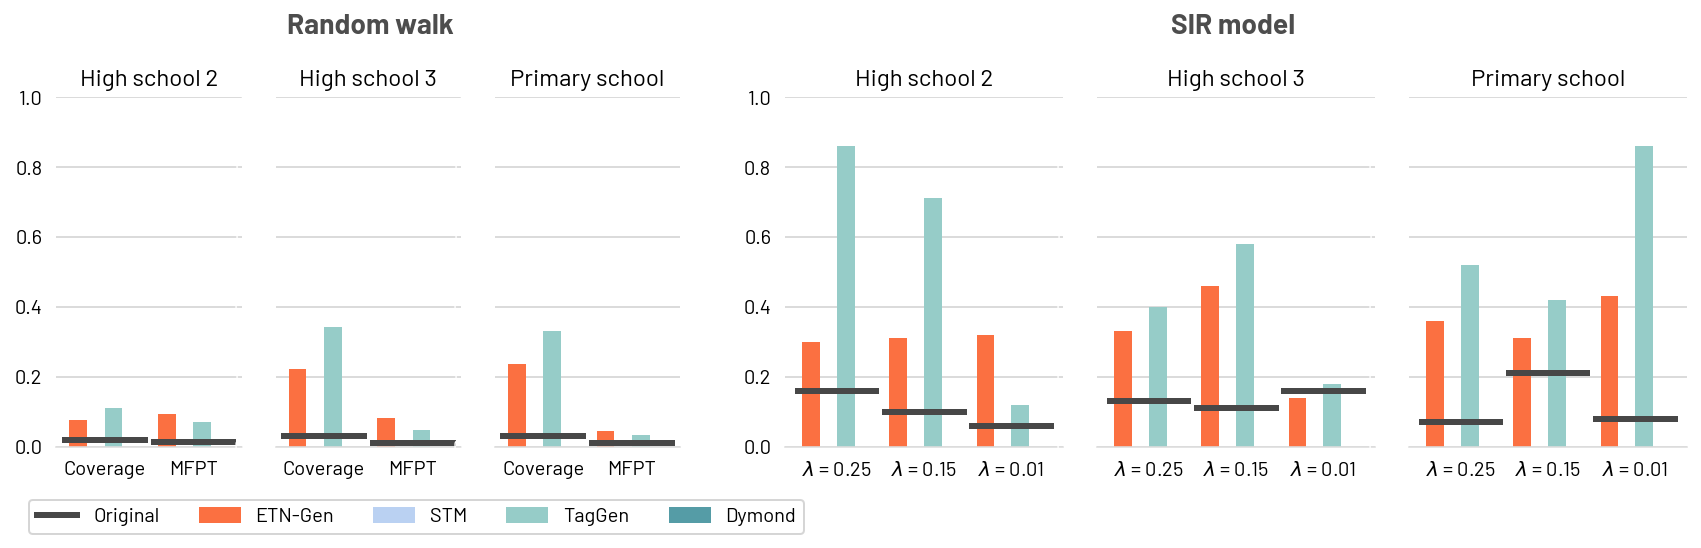

In [90]:
fig, ax = plt.subplots(1,7, figsize=(12,3), gridspec_kw={'width_ratios': [1,1,1,0.2,1.5,1.5,1.5]})
fig.tight_layout(w_pad=-1)


plot_cov_mfpt3(ax[0],"High_School12")
plot_cov_mfpt3(ax[1],"High_School13")
plot_cov_mfpt3(ax[2],"primary_school",legend=True)

empty_plot(ax[3])

plot_r03(ax[4],"High_School12")
plot_r03(ax[5],"High_School13")
plot_r03(ax[6],"primary_school",legend=True)


ax[1].tick_params(axis='y', colors='white')
ax[2].tick_params(axis='y', colors='white')

#ax[4].tick_params(axis='y', colors='white')
ax[5].tick_params(axis='y', colors='white')
ax[6].tick_params(axis='y', colors='white')

legend_elements = [Line2D([0], [0], color=ORIGINAL_COLOR, lw=3,label='Original'),
                   Patch(facecolor=ETN_COLOR, edgecolor=ETN_COLOR,label='ETN-Gen'),
                   Patch(facecolor=STM_COLOR, edgecolor=STM_COLOR,label='STM'),
                   Patch(facecolor=TAG_COLOR, edgecolor=TAG_COLOR,label='TagGen'),
                   Patch(facecolor=DYM_COLOR, edgecolor=DYM_COLOR,label='Dymond')]

# Create the figure
ax[0].legend(handles=legend_elements,loc='center left', bbox_to_anchor=(-0.2, -0.2),ncol=5)

fig.text(0.17, 1.08, 'Random walk',fontdict={'size':14,'color':'#4d4d4d'},weight="bold")
fig.text(0.682, 1.08, 'SIR model',fontdict={'size':14,'color':'#4d4d4d'},weight="bold")


#fig.savefig("dynamic_main_test_WithE_V5.pdf", bbox_inches = 'tight')